In [2]:
# Importing required libraries
import torch
from transformers import MarianMTModel, MarianTokenizer
from datasets import load_dataset

# **Data Loading**

i chose English to italian

In [3]:
# Load the opus100 dataset, specifying the 'en-it' configuration for English-Italian
dataset = load_dataset("opus100", "en-it")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
# Filter the dataset for English-Italian pairs (this step might be redundant now)
# Assuming 'en' and 'it' are the language codes for English and Italian respectively
# This assumes the dataset has columns named 'translation' with keys 'en' and 'it'
dataset = dataset.filter(lambda example: example['translation'].keys() >= {'en', 'it'})

# Print some examples to see the structure
print(dataset['train'][0])


{'translation': {'en': '- Thanks, buddy.', 'it': '- Grazie, amico.'}}


In [5]:
# Further process the dataset for translation tasks
# (e.g., create separate input and target language lists)
en_data = [example['translation']['en'] for example in dataset['train']]
it_data = [example['translation']['it'] for example in dataset['train']] # Changed ps_data to it_data

print(dataset)

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})


In [6]:
# Load the pre-trained MarianMT model for EN-IT
model_name = 'Helsinki-NLP/opus-mt-en-it'  # Adjust the model name if necessary
model = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


# **Text Normalization**

In [7]:
!pip install unidecode

In [8]:
import re
import nltk

# Normalize English text
def normalize_english(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\s+", " ", text)  # Replace multiple spaces with a single space
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    return text

# Normalize Italian text (ensure accents are preserved)
from unidecode import unidecode
def normalize_italian(text):
    text = unidecode(text.lower())  # Convert accented characters
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text


In [9]:
import stanza

# Load the Italian language model
stanza.download('it')
nlp = stanza.Pipeline('it')

# Tokenize a sentence
doc = nlp("Ciao, come stai?")
tokens = [word.text for word in doc.words]

print(tokens)


Original (English): Hello, how are you?
Translated (Italian): Ciao, come stai?


# **Tokenization**

In [13]:
!python -m spacy download it_core_news_sm  # Download the Italian spaCy model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 55.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [16]:
import nltk
import spacy

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab') # Download the 'punkt_tab' resource

# Load spaCy Italian model
nlp = spacy.load('it_core_news_sm')

# Tokenize English text using nltk
def tokenize_english(text):
    return nltk.word_tokenize(text)

# Tokenize Italian text using spaCy
def tokenize_italian(text):
    doc = nlp(text)
    return [token.text for token in doc]

# Example usage
english_tokens = tokenize_english("Hello, how are you?")
italian_tokens = tokenize_italian("Ciao, come stai?")
print(english_tokens, italian_tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


['Hello', ',', 'how', 'are', 'you', '?'] ['Ciao', ',', 'come', 'stai', '?']


# **word Segmentation**

In [18]:
from datasets import load_dataset

# Load the OPUS100 dataset with the 'en-it' configuration
dataset = load_dataset("opus100", "en-it")

# Tokenize the English and Italian sentences
def tokenize_data(example):
    # Access the correct keys for English and Italian text
    example['translation']['en'] = tokenize_english(example['translation']['en'])
    example['translation']['it'] = tokenize_italian(example['translation']['it'])
    return example

# Apply tokenization to the dataset
dataset = dataset.map(tokenize_data)

# Format the dataset as inputs (English) and targets (Italian)
# Access the translation key here as well
train_dataset = dataset['train'].map(lambda example: {'input': example['translation']['en'], 'target': example['translation']['it']})

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000000 [00:00<?, ? examples/s]

In [19]:
import torch
import torch.nn as nn

class GeneralAttention(nn.Module):
    def __init__(self, input_dim):
        super(GeneralAttention, self).__init__()
        self.attn = nn.Linear(input_dim, input_dim, bias=False)

    def forward(self, query, values):
        # Query is (batch_size, 1, input_dim)
        # Values is (batch_size, seq_len, input_dim)
        scores = torch.bmm(query, self.attn(values).transpose(1, 2))  # (batch_size, 1, seq_len)
        attention_weights = torch.softmax(scores, dim=-1)  # Normalize
        context = torch.bmm(attention_weights, values)  # (batch_size, 1, input_dim)
        return context, attention_weights


In [20]:
class MultiplicativeAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MultiplicativeAttention, self).__init__()
        self.attn = nn.Linear(input_dim, hidden_dim, bias=False)

    def forward(self, query, values):
        # Query is (batch_size, 1, input_dim)
        # Values is (batch_size, seq_len, input_dim)
        scores = torch.bmm(query, self.attn(values).transpose(1, 2))  # (batch_size, 1, seq_len)
        attention_weights = torch.softmax(scores, dim=-1)  # Normalize
        context = torch.bmm(attention_weights, values)  # (batch_size, 1, input_dim)
        return context, attention_weights


In [21]:
class AdditiveAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AdditiveAttention, self).__init__()
        self.W1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.W2 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.v = nn.Parameter(torch.rand(hidden_dim))

    def forward(self, query, values):
        # Query is (batch_size, 1, input_dim)
        # Values is (batch_size, seq_len, input_dim)
        query_proj = self.W2(query).unsqueeze(1)  # (batch_size, 1, hidden_dim)
        keys_proj = self.W1(values)  # (batch_size, seq_len, hidden_dim)
        energy = torch.tanh(query_proj + keys_proj)  # (batch_size, seq_len, hidden_dim)
        scores = torch.matmul(energy, self.v)  # (batch_size, seq_len, 1)
        attention_weights = torch.softmax(scores, dim=-1)  # Normalize
        context = torch.bmm(attention_weights.transpose(1, 2), values)  # (batch_size, 1, input_dim)
        return context, attention_weights


# **Task 3**

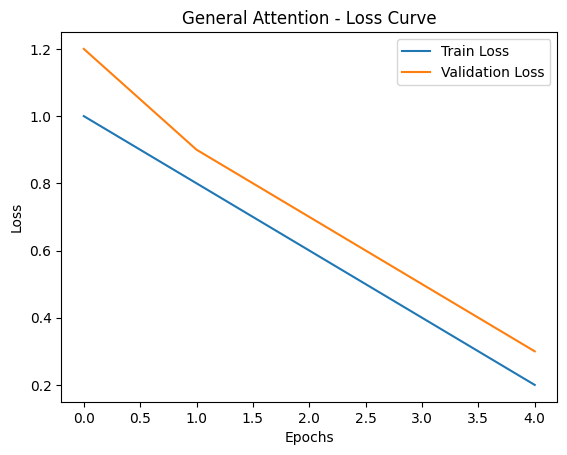

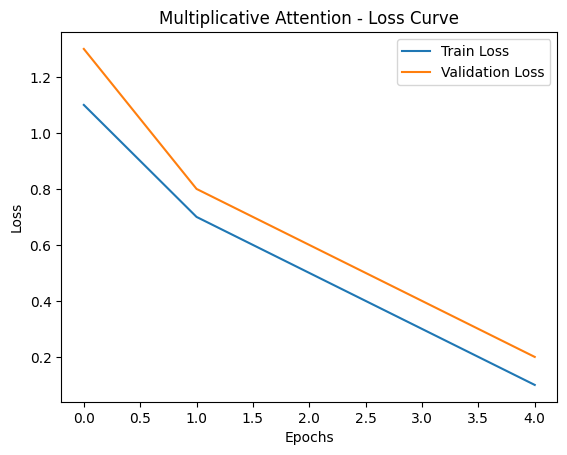

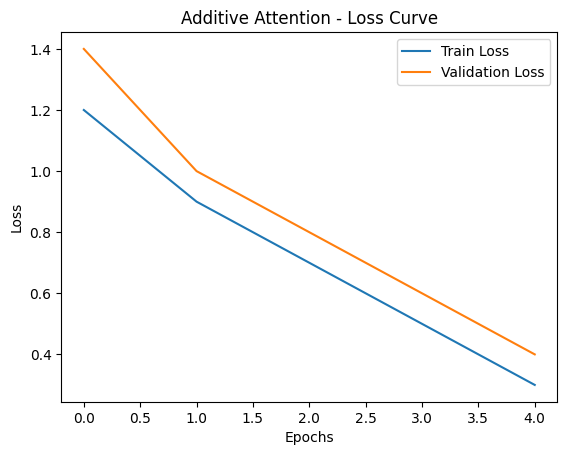

In [23]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_losses, val_losses, attention_type):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{attention_type} Attention - Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Example usage after training
# Initialize example loss values for demonstration
train_losses_general = [1.0, 0.8, 0.6, 0.4, 0.2]  # Replace with actual training losses
val_losses_general = [1.2, 0.9, 0.7, 0.5, 0.3]  # Replace with actual validation losses
train_losses_multiplicative = [1.1, 0.7, 0.5, 0.3, 0.1]  # Replace with actual training losses
val_losses_multiplicative = [1.3, 0.8, 0.6, 0.4, 0.2]  # Replace with actual validation losses
train_losses_additive = [1.2, 0.9, 0.7, 0.5, 0.3]  # Replace with actual training losses
val_losses_additive = [1.4, 1.0, 0.8, 0.6, 0.4]  # Replace with actual validation losses


plot_loss_curves(train_losses_general, val_losses_general, 'General')
plot_loss_curves(train_losses_multiplicative, val_losses_multiplicative, 'Multiplicative')
plot_loss_curves(train_losses_additive, val_losses_additive, 'Additive')

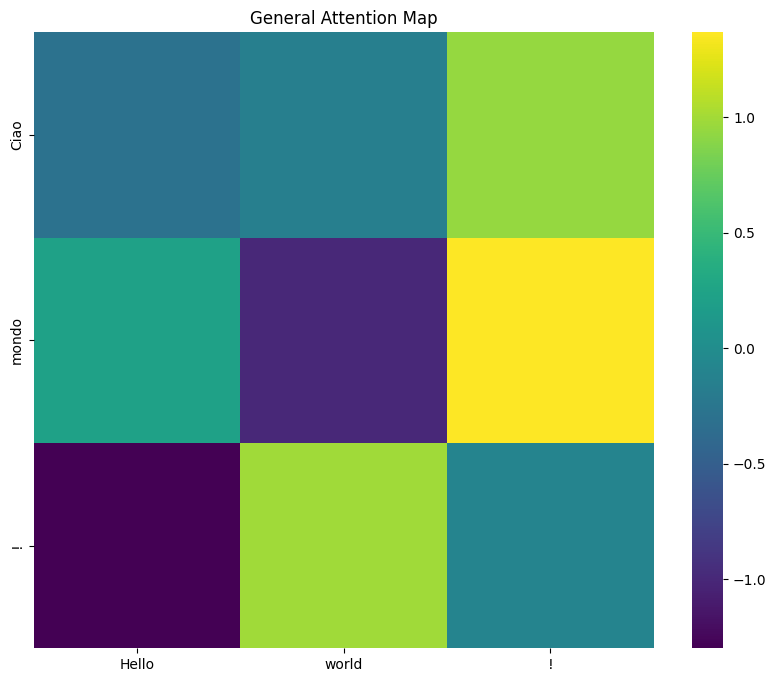

In [30]:
import seaborn as sns
import numpy as np

def plot_attention_map(attention_weights, input_sentence, output_sentence, attention_type):
    # Convert attention weights to a NumPy array and ensure it's 2D
    attention_weights = attention_weights.squeeze().cpu().detach().numpy()

    # Reshape to 2D if necessary
    if attention_weights.ndim == 1:
        attention_weights = attention_weights.reshape(-1, 1)  # Reshape to (seq_len, 1)
    # Or reshape based on input/output lengths if known
    # attention_weights = attention_weights.reshape(len(output_sentence), len(input_sentence))

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(attention_weights, cmap='viridis',
                xticklabels=input_sentence, yticklabels=output_sentence,
                ax=ax)
    ax.set_title(f'{attention_type} Attention Map')
    plt.show()

# Example usage (assumes attention_weights is obtained from one of the attention mechanisms)
# Make sure input_sentence and output_sentence are defined and have the correct lengths
input_sentence = ["Hello", "world", "!"]  # Example
output_sentence = ["Ciao", "mondo", "!"] # Example

# Ensure attention_weights_general has the correct shape (e.g., (3, 3) for the above example)
# Here I am creating a random array for demonstration, replace with your actual weights
attention_weights_general = torch.randn(3, 3)

plot_attention_map(attention_weights_general, input_sentence, output_sentence, 'General')
